#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/Users/pavelfedorov/Data_for_projects/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


У нас есть исторические данные о заказах такси в аэропортах с 1 марта по 31 августа 2018г.
Пропуски отсутствуют, данные идут последовательно

In [4]:
df = df.resample('1H').sum()

Проверим последовательность ряда:

In [5]:
df.index.is_monotonic_increasing

True

## Анализ

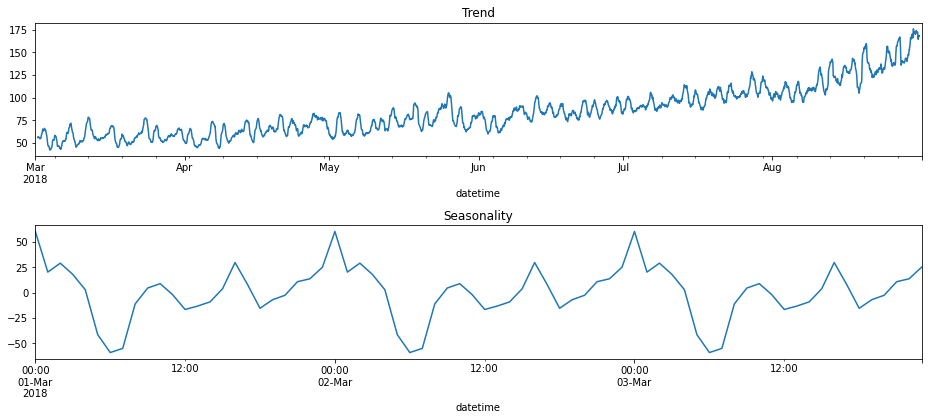

In [6]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(13, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.tight_layout()

Заметин тренд на увеличиение заказов к лету, а также видна сезонность заказов в течении дня

Подготовим признаки для модели

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

In [8]:
data = make_features(df, 24, 24)
data.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим данные на обучающую и тестовую выборку в соотношении 9:1

In [9]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

feature_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

feature_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print('Признаки обучающей выборки:',feature_train.shape)  
print('Целевой признак обучающей выборки:', target_train.shape)
print('Признаки тестовой выборки:',feature_test.shape)  
print('Целевой признак тестовой выборки:', target_test.shape)

Признаки обучающей выборки: (3950, 26)
Целевой признак обучающей выборки: (3950,)
Признаки тестовой выборки: (442, 26)
Целевой признак тестовой выборки: (442,)


## Обучение

Используем 3 модели для предсказания:

    * Линейная регрессия
    * Случайный лес
    * LGBMRegressor

In [10]:
# Зададим парметры сетки
parameters = {'num_leaves':range(60, 70),
              'max_depth':range(7, 10),
              'learning_rate':[0.1, 0.2]
             }

# Определяем модель
lgb_model = lgb.LGBMRegressor(n_jobs=-1)
clf = RandomizedSearchCV(lgb_model,
                 parameters,
                 scoring='neg_root_mean_squared_error',
                 cv = TimeSeriesSplit(n_splits=8),
                 random_state=42)

clf.fit(feature_train, target_train)
print(clf.best_params_)

{'num_leaves': 65, 'max_depth': 7, 'learning_rate': 0.1}


In [11]:
# Зададим парметры сетки
parametrs_RFR = { 'n_estimators': range (80, 151, 10),
                  'max_depth': range (10,20),
                  'min_samples_leaf': range (10,20)
               }

# Определяем модель
RFR_model = RandomForestRegressor(n_jobs=-1)
clf_RFR = RandomizedSearchCV(RFR_model,
                 parametrs_RFR,
                 scoring='neg_root_mean_squared_error',
                 cv = TimeSeriesSplit(n_splits=8),
                 random_state=42)

clf_RFR.fit(feature_train, target_train)
print(clf_RFR.best_params_)

{'n_estimators': 100, 'min_samples_leaf': 11, 'max_depth': 16}


In [12]:
final_model_lgb = lgb_model.set_params(**clf.best_params_)
final_model_RFR = RFR_model.set_params(**clf_RFR.best_params_)
model = LinearRegression()

In [13]:
# обучение линейной регрессией


print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''',
                         "%.3f" % abs(cross_val_score(model,feature_train, target_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()))
print(f'''Значение метрики RMSE на обучающей выборке для LGBMRegressor''',
                         "%.3f" % abs(cross_val_score(final_model_lgb,feature_train, target_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()))
print(f'''Значение метрики RMSE на обучающей выборке для RandomForestRegressor''',
                         "%.3f" % abs(cross_val_score(final_model_RFR,feature_train, target_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()))

Значение метрики RMSE на обучающей выборке для LinearRegression 26.717
Значение метрики RMSE на обучающей выборке для LGBMRegressor 25.040
Значение метрики RMSE на обучающей выборке для RandomForestRegressor 25.577


Используем лучшую модель на тесте:

## Тестирование

In [14]:
final_model_lgb.fit(feature_train, target_train)
predicted_fmlgb = final_model_lgb.predict(feature_test)
print('RMSE:')
print((mean_squared_error(target_test , predicted_fmlgb)**0.5))

RMSE:
41.84609551451037


В моделе LGBMRegressor, значение RMSE меньше 48

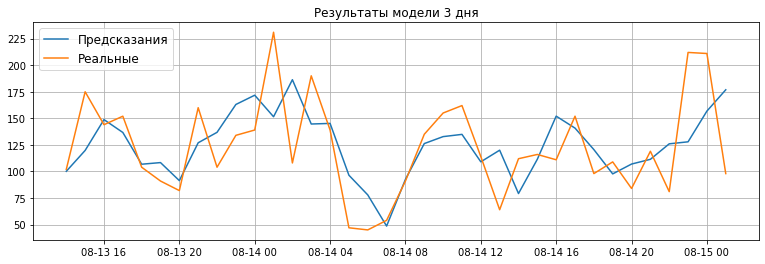

In [15]:
plt.figure(figsize=(13, 4))

predictions = pd.Series(predicted_fmlgb,index=target_test.index).head(36)
target = target_test.head(36)

plt.plot(predictions, label='Предсказания')
plt.plot(target, label='Реальные')
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.title('Результаты модели 3 дня')
plt.show()

## Вывод

В результате проделанной работы была построена модель прогнозирования количества заказов такси. В модели мы использовали алгоритм LGBMRegressor с гиперпараметрами ('num_leaves': 65, 'max_depth': 7, 'learning_rate': 0.1) , на тестовой выборке модель показала RMSE - 41.85.